<a href="https://colab.research.google.com/github/cindyzakya/IR-Final-Project-Identifikasi-Penulis-Horor-/blob/main/IR_Final_Project_(XG_Boost_%2B_Multinomial_Naive_Bayes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IR-2025-Identifikasi Penulis Horor**

###**1. Setup Awal**

In [1]:
# Import library yang diperlukan
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import xgboost as xgb
import itertools

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

nltk.download('stopwords')

color = sns.color_palette()
eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path Google Drive
base_dir = '/content/drive/MyDrive/IR-Spooky_Author'
os.makedirs(base_dir, exist_ok=True)

In [4]:
# Path spesifik
train_path = os.path.join(base_dir, 'train.csv')
test_path = os.path.join(base_dir, 'test.csv')
sample_submission_path = os.path.join(base_dir, 'sample_submission.csv')

###**2. Eksplorasi Data (EDA)**

In [5]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [6]:
# Preview the data
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (19579, 3)
Test data shape: (8392, 2)


In [7]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
# Melihat distribusi kelas (label target)
print("\nClass distribution in training data:")
print(train_df['author'].value_counts())


Class distribution in training data:
author
EAP    7900
MWS    6044
HPL    5635
Name: count, dtype: int64


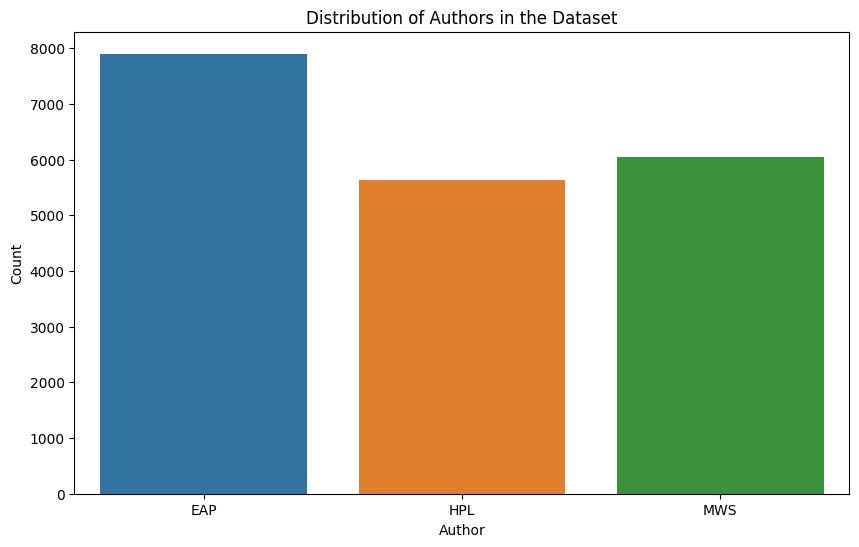

In [9]:
# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='author', data=train_df, hue='author', legend=False)
plt.title('Distribution of Authors in the Dataset')
plt.xlabel('Author')
plt.ylabel('Count')
plt.show()

In [10]:
# Melihat beberapa sampel (5 sampel) teks per kelas
grouped_df = train_df.groupby('author')

In [11]:
for author_name, group in grouped_df:
    print("Author name : ", author_name)
    count = 0
    for i, row in group.iterrows():
        print(row["text"])
        count += 1
        if count == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

####**META FEATURES**

####**Menambahkan dan Menganalisis Fitur Statistik Sederhana**
1. num_words: Jumlah kata.
2. num_different_words: Kata unik
3. num_chars: Jumlah karakter
4. num_stopwords: Kata yang merupakan stopwords.
5. num_punctuations: Jumlah tanda baca.
6. mean_word_len: Panjang rata-rata kata.






In [12]:
# Number of words in the text
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

In [13]:
# Size of the vocabulary used in the text
train_df["num_different_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_different_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

In [14]:
# Number of characters in the text
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

In [15]:
# Number of stopwords in the text
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

In [16]:
# Number of punctuations in the text
train_df["num_punctuations"] = train_df['text'].apply(lambda x: len([p for p in str(x) if p in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([p for p in str(x) if p in string.punctuation]) )

In [17]:
# Average length of the words in the text
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

####**Visualisasi Distribusi Fitur Berdasarkan Kelas**

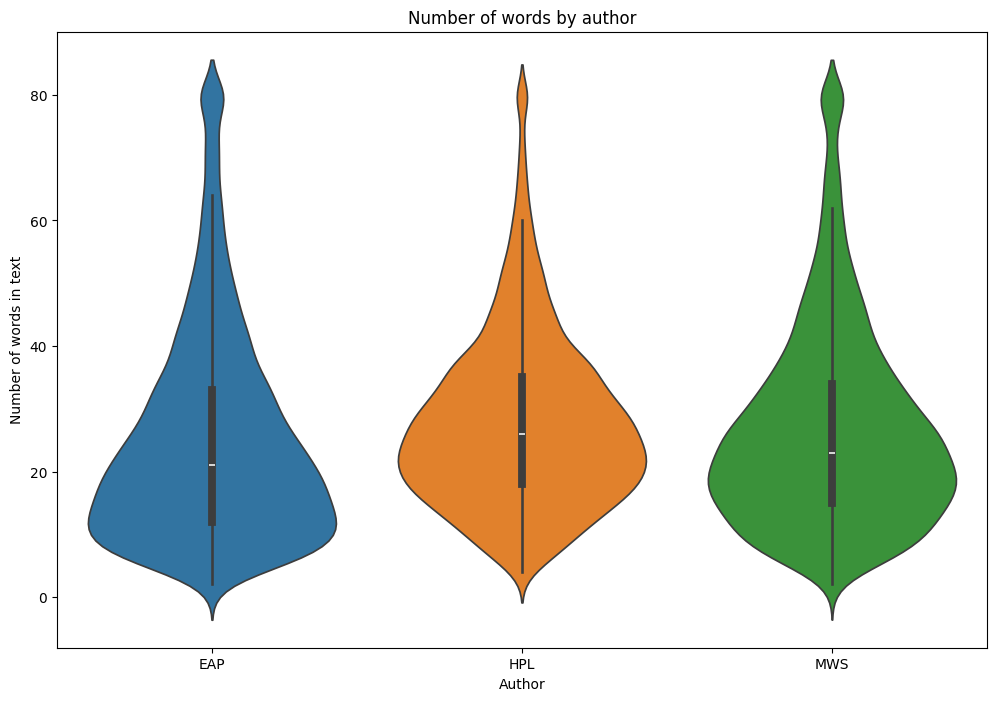

In [18]:
train_df.loc[train_df['num_words'] > 80, 'num_words'] = 80
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df, hue='author', legend=False)
plt.xlabel('Author')
plt.ylabel('Number of words in text')
plt.title("Number of words by author")
plt.show()

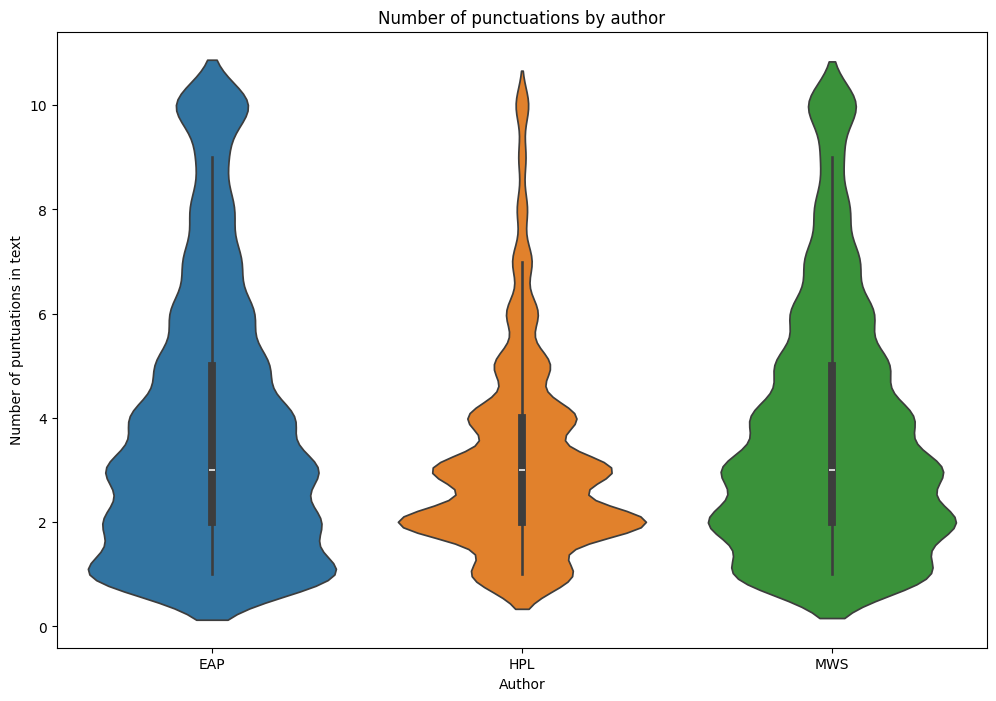

In [19]:
train_df.loc[train_df['num_punctuations'] > 10, 'num_punctuations'] = 10
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df, hue='author', legend=False)
plt.xlabel('Author')
plt.ylabel('Number of puntuations in text')
plt.title("Number of punctuations by author")
plt.show()

###**3. Persiapan untuk Modeling**

In [20]:
# Prepare the data for modeling
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

In [21]:
# Recompute the trauncated variables again
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train_df["num_punctuations"] = train_df['text'].apply(lambda x: len([p for p in str(x) if p in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([p for p in str(x) if p in string.punctuation]) )

In [22]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

###**4. Training Function dengan Model XGBoost**

In [23]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
        pred_test_y = model.predict(xgtest)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        pred_test_y = model.predict(xgtest)

    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2)
    else:
        pred_test_y2 = None

    return pred_test_y, pred_test_y2, model

###**5. Cross Validation dengan XGBoost**

In [24]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

[0]	train-mlogloss:1.09418	test-mlogloss:1.09494
[20]	train-mlogloss:1.05865	test-mlogloss:1.06745
[40]	train-mlogloss:1.04662	test-mlogloss:1.05890


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:19:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	train-mlogloss:1.04007	test-mlogloss:1.05494
[80]	train-mlogloss:1.03402	test-mlogloss:1.05081
[100]	train-mlogloss:1.02909	test-mlogloss:1.04755
[120]	train-mlogloss:1.02584	test-mlogloss:1.04587
[140]	train-mlogloss:1.02175	test-mlogloss:1.04315
[160]	train-mlogloss:1.01858	test-mlogloss:1.04096
[180]	train-mlogloss:1.01601	test-mlogloss:1.03994
[200]	train-mlogloss:1.01363	test-mlogloss:1.03838
[220]	train-mlogloss:1.01115	test-mlogloss:1.03748
[240]	train-mlogloss:1.00925	test-mlogloss:1.03669
[260]	train-mlogloss:1.00730	test-mlogloss:1.03619
[280]	train-mlogloss:1.00552	test-mlogloss:1.03534
[300]	train-mlogloss:1.00400	test-mlogloss:1.03528
[320]	train-mlogloss:1.00259	test-mlogloss:1.03516
[340]	train-mlogloss:1.00108	test-mlogloss:1.03485
[360]	train-mlogloss:0.99961	test-mlogloss:1.03423
[380]	train-mlogloss:0.99828	test-mlogloss:1.03396
[400]	train-mlogloss:0.99712	test-mlogloss:1.03374
[420]	train-mlogloss:0.99584	test-mlogloss:1.03361
[440]	train-mlogloss:0.99478	test

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:19:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	train-mlogloss:1.04355	test-mlogloss:1.04364
[80]	train-mlogloss:1.03751	test-mlogloss:1.03911
[100]	train-mlogloss:1.03251	test-mlogloss:1.03545
[120]	train-mlogloss:1.02924	test-mlogloss:1.03388
[140]	train-mlogloss:1.02512	test-mlogloss:1.03140
[160]	train-mlogloss:1.02182	test-mlogloss:1.02966
[180]	train-mlogloss:1.01916	test-mlogloss:1.02857
[200]	train-mlogloss:1.01662	test-mlogloss:1.02737
[220]	train-mlogloss:1.01435	test-mlogloss:1.02653
[240]	train-mlogloss:1.01235	test-mlogloss:1.02579
[260]	train-mlogloss:1.01045	test-mlogloss:1.02500
[280]	train-mlogloss:1.00873	test-mlogloss:1.02431
[300]	train-mlogloss:1.00719	test-mlogloss:1.02386
[320]	train-mlogloss:1.00579	test-mlogloss:1.02366
[340]	train-mlogloss:1.00427	test-mlogloss:1.02325
[360]	train-mlogloss:1.00289	test-mlogloss:1.02274
[380]	train-mlogloss:1.00160	test-mlogloss:1.02217
[400]	train-mlogloss:1.00041	test-mlogloss:1.02212
[420]	train-mlogloss:0.99909	test-mlogloss:1.02176
[440]	train-mlogloss:0.99798	test

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:19:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	train-mlogloss:1.04047	test-mlogloss:1.05295
[80]	train-mlogloss:1.03425	test-mlogloss:1.04937
[100]	train-mlogloss:1.02913	test-mlogloss:1.04677
[120]	train-mlogloss:1.02586	test-mlogloss:1.04525
[140]	train-mlogloss:1.02158	test-mlogloss:1.04345
[160]	train-mlogloss:1.01820	test-mlogloss:1.04219
[180]	train-mlogloss:1.01547	test-mlogloss:1.04095
[200]	train-mlogloss:1.01285	test-mlogloss:1.04011
[220]	train-mlogloss:1.01058	test-mlogloss:1.03923
[240]	train-mlogloss:1.00853	test-mlogloss:1.03876
[260]	train-mlogloss:1.00659	test-mlogloss:1.03803
[280]	train-mlogloss:1.00488	test-mlogloss:1.03739
[300]	train-mlogloss:1.00326	test-mlogloss:1.03704
[320]	train-mlogloss:1.00178	test-mlogloss:1.03669
[340]	train-mlogloss:1.00030	test-mlogloss:1.03612
[360]	train-mlogloss:0.99891	test-mlogloss:1.03573
[380]	train-mlogloss:0.99770	test-mlogloss:1.03524
[400]	train-mlogloss:0.99647	test-mlogloss:1.03505
[420]	train-mlogloss:0.99521	test-mlogloss:1.03467
[440]	train-mlogloss:0.99414	test

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:19:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	train-mlogloss:1.04272	test-mlogloss:1.04537
[80]	train-mlogloss:1.03690	test-mlogloss:1.04088
[100]	train-mlogloss:1.03200	test-mlogloss:1.03753
[120]	train-mlogloss:1.02874	test-mlogloss:1.03633
[140]	train-mlogloss:1.02457	test-mlogloss:1.03341
[160]	train-mlogloss:1.02136	test-mlogloss:1.03147
[180]	train-mlogloss:1.01866	test-mlogloss:1.03015
[200]	train-mlogloss:1.01614	test-mlogloss:1.02881
[220]	train-mlogloss:1.01395	test-mlogloss:1.02756
[240]	train-mlogloss:1.01204	test-mlogloss:1.02666
[260]	train-mlogloss:1.01011	test-mlogloss:1.02581
[280]	train-mlogloss:1.00842	test-mlogloss:1.02536
[300]	train-mlogloss:1.00688	test-mlogloss:1.02460
[320]	train-mlogloss:1.00553	test-mlogloss:1.02443
[340]	train-mlogloss:1.00403	test-mlogloss:1.02417
[360]	train-mlogloss:1.00260	test-mlogloss:1.02389
[380]	train-mlogloss:1.00131	test-mlogloss:1.02318
[400]	train-mlogloss:1.00019	test-mlogloss:1.02294
[420]	train-mlogloss:0.99891	test-mlogloss:1.02231
[440]	train-mlogloss:0.99778	test

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:19:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	train-mlogloss:1.04154	test-mlogloss:1.04878
[80]	train-mlogloss:1.03568	test-mlogloss:1.04463
[100]	train-mlogloss:1.03067	test-mlogloss:1.04131
[120]	train-mlogloss:1.02761	test-mlogloss:1.03948
[140]	train-mlogloss:1.02351	test-mlogloss:1.03668
[160]	train-mlogloss:1.02035	test-mlogloss:1.03450
[180]	train-mlogloss:1.01786	test-mlogloss:1.03330
[200]	train-mlogloss:1.01536	test-mlogloss:1.03213
[220]	train-mlogloss:1.01317	test-mlogloss:1.03117
[240]	train-mlogloss:1.01123	test-mlogloss:1.03034
[260]	train-mlogloss:1.00939	test-mlogloss:1.02949
[280]	train-mlogloss:1.00774	test-mlogloss:1.02855
[300]	train-mlogloss:1.00626	test-mlogloss:1.02823
[320]	train-mlogloss:1.00485	test-mlogloss:1.02815
[340]	train-mlogloss:1.00344	test-mlogloss:1.02796
[360]	train-mlogloss:1.00199	test-mlogloss:1.02773
[380]	train-mlogloss:1.00072	test-mlogloss:1.02741
[400]	train-mlogloss:0.99955	test-mlogloss:1.02717
[420]	train-mlogloss:0.99833	test-mlogloss:1.02687
[440]	train-mlogloss:0.99729	test

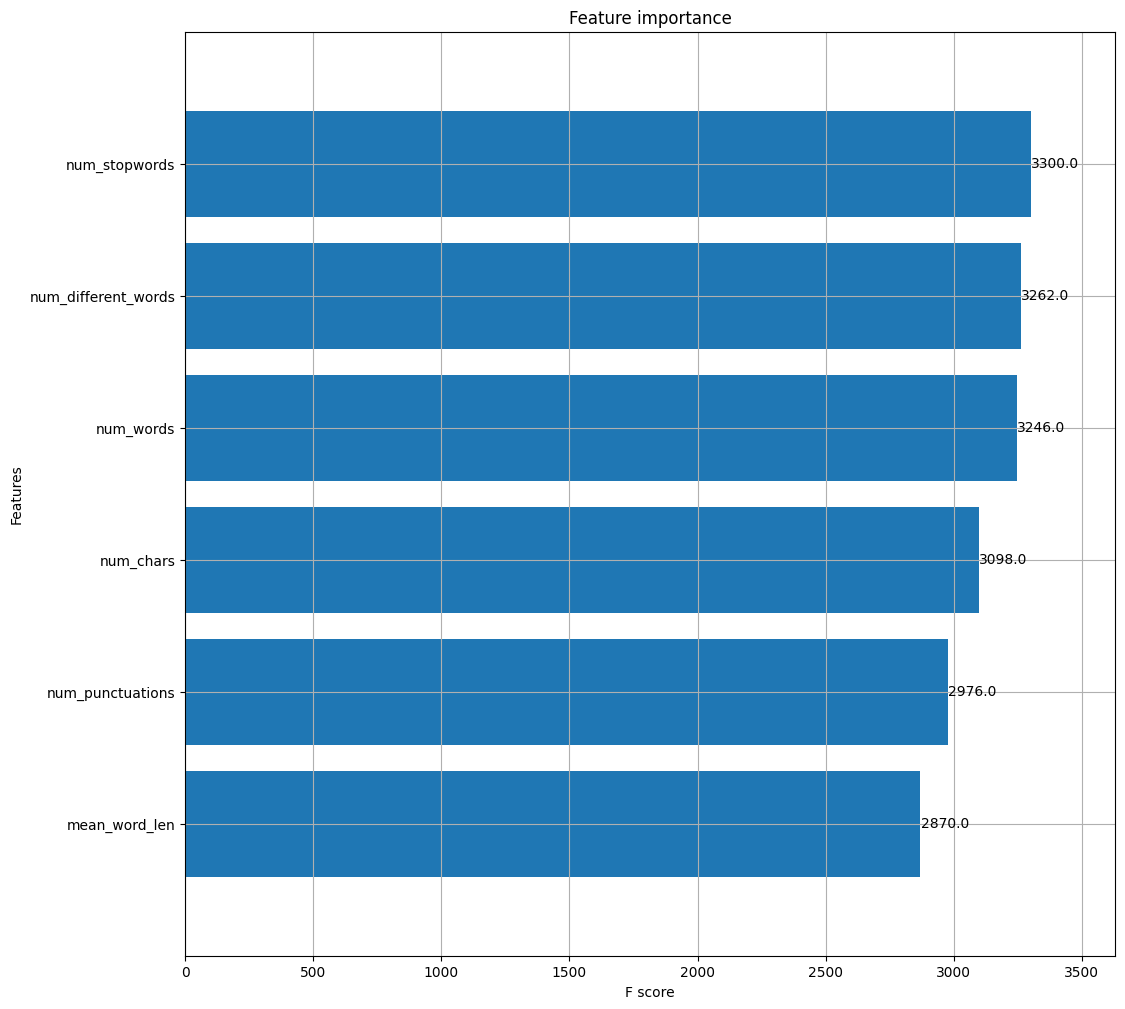

In [25]:
# Plot the important variables
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

###**6. TF-IDF dan Naive Bayes**

In [26]:
# Fit transform the tfidf vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

###**7. Training Function Naive Bayes**

In [27]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

###**8. Cross Validation dengan Naive Bayes**

In [28]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.842216198361285


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
       print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1531   17   47]
 [ 554  500   44]
 [ 487   11  724]]


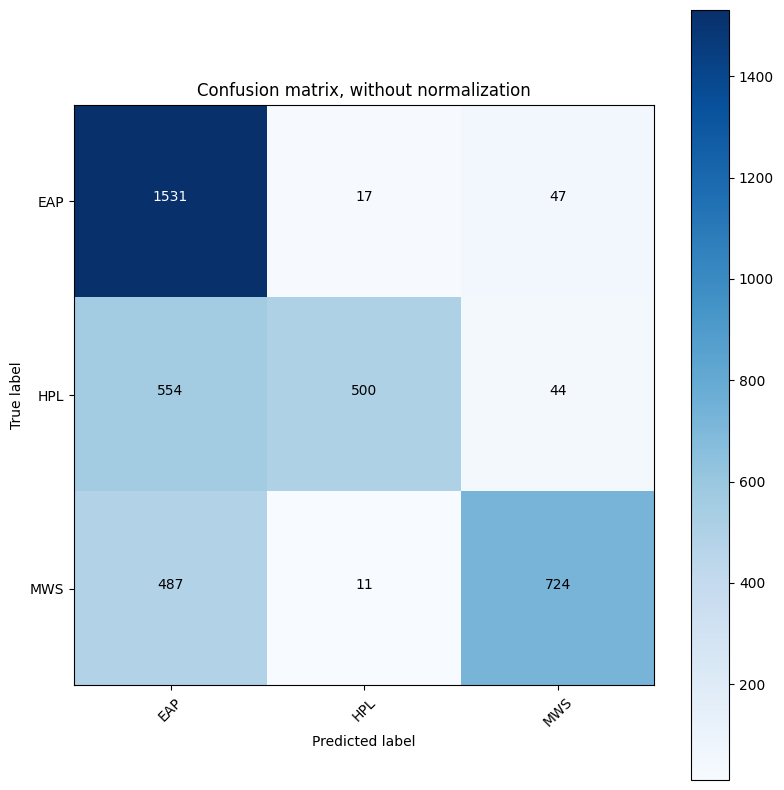

In [30]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

In [31]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [32]:
# Fit transform the count vectorizer
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [33]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)

    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.4509184161656742


Confusion matrix, without normalization
[[1331   92  172]
 [ 124  898   76]
 [ 129   53 1040]]


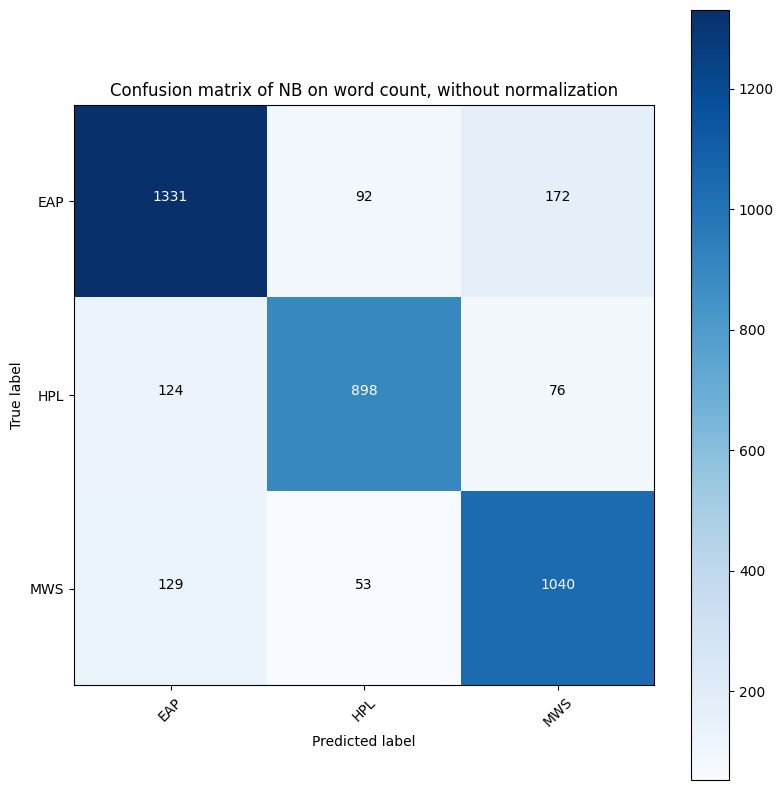

In [34]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [35]:
# Fit transform the tfidf vectorizer #
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.8528982526171456


In [36]:
# Fit transform the tfidf vectorizer #
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947422


In [37]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [38]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:23:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.00071	test-mlogloss:1.00055
[20]	train-mlogloss:0.41251	test-mlogloss:0.41689
[40]	train-mlogloss:0.34149	test-mlogloss:0.35345
[60]	train-mlogloss:0.31530	test-mlogloss:0.33464
[80]	train-mlogloss:0.29797	test-mlogloss:0.32424
[100]	train-mlogloss:0.28486	test-mlogloss:0.31835
[120]	train-mlogloss:0.27351	test-mlogloss:0.31440
[140]	train-mlogloss:0.26423	test-mlogloss:0.31117
[160]	train-mlogloss:0.25561	test-mlogloss:0.30957
[180]	train-mlogloss:0.24792	test-mlogloss:0.30829
[200]	train-mlogloss:0.24115	test-mlogloss:0.30730
[220]	train-mlogloss:0.23437	test-mlogloss:0.30659
[240]	train-mlogloss:0.22814	test-mlogloss:0.30611
[260]	train-mlogloss:0.22251	test-mlogloss:0.30588
[280]	train-mlogloss:0.21695	test-mlogloss:0.30593
[300]	train-mlogloss:0.21135	test-mlogloss:0.30596
[320]	train-mlogloss:0.20573	test-mlogloss:0.30612
[338]	train-mlogloss:0.20123	test-mlogloss:0.30642
[0]	train-mlogloss:1.00077	test-mlogloss:1.00170


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:23:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	train-mlogloss:0.41128	test-mlogloss:0.42003
[40]	train-mlogloss:0.34015	test-mlogloss:0.35555
[60]	train-mlogloss:0.31335	test-mlogloss:0.33781
[80]	train-mlogloss:0.29522	test-mlogloss:0.32855
[100]	train-mlogloss:0.28164	test-mlogloss:0.32374
[120]	train-mlogloss:0.27062	test-mlogloss:0.32038
[140]	train-mlogloss:0.26102	test-mlogloss:0.31773
[160]	train-mlogloss:0.25254	test-mlogloss:0.31655
[180]	train-mlogloss:0.24507	test-mlogloss:0.31536
[200]	train-mlogloss:0.23798	test-mlogloss:0.31503
[220]	train-mlogloss:0.23113	test-mlogloss:0.31383
[240]	train-mlogloss:0.22469	test-mlogloss:0.31348
[260]	train-mlogloss:0.21866	test-mlogloss:0.31339
[280]	train-mlogloss:0.21264	test-mlogloss:0.31358
[300]	train-mlogloss:0.20704	test-mlogloss:0.31318
[320]	train-mlogloss:0.20189	test-mlogloss:0.31286
[340]	train-mlogloss:0.19661	test-mlogloss:0.31261
[360]	train-mlogloss:0.19168	test-mlogloss:0.31229
[380]	train-mlogloss:0.18701	test-mlogloss:0.31223
[400]	train-mlogloss:0.18236	test-m

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	train-mlogloss:0.40942	test-mlogloss:0.42538
[40]	train-mlogloss:0.33841	test-mlogloss:0.36254
[60]	train-mlogloss:0.31152	test-mlogloss:0.34433
[80]	train-mlogloss:0.29450	test-mlogloss:0.33600
[100]	train-mlogloss:0.28059	test-mlogloss:0.33014
[120]	train-mlogloss:0.26951	test-mlogloss:0.32717
[140]	train-mlogloss:0.25984	test-mlogloss:0.32474
[160]	train-mlogloss:0.25152	test-mlogloss:0.32368
[180]	train-mlogloss:0.24359	test-mlogloss:0.32233
[200]	train-mlogloss:0.23642	test-mlogloss:0.32211
[220]	train-mlogloss:0.22967	test-mlogloss:0.32115
[240]	train-mlogloss:0.22329	test-mlogloss:0.32075
[260]	train-mlogloss:0.21695	test-mlogloss:0.32037
[280]	train-mlogloss:0.21108	test-mlogloss:0.32011
[300]	train-mlogloss:0.20545	test-mlogloss:0.32019
[320]	train-mlogloss:0.20011	test-mlogloss:0.32076
[339]	train-mlogloss:0.19520	test-mlogloss:0.32067
[0]	train-mlogloss:1.00107	test-mlogloss:1.00043


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	train-mlogloss:0.41362	test-mlogloss:0.41307
[40]	train-mlogloss:0.34208	test-mlogloss:0.34856
[60]	train-mlogloss:0.31612	test-mlogloss:0.32933
[80]	train-mlogloss:0.29911	test-mlogloss:0.32050
[100]	train-mlogloss:0.28569	test-mlogloss:0.31408
[120]	train-mlogloss:0.27442	test-mlogloss:0.31042
[140]	train-mlogloss:0.26466	test-mlogloss:0.30745
[160]	train-mlogloss:0.25635	test-mlogloss:0.30569
[180]	train-mlogloss:0.24875	test-mlogloss:0.30428
[200]	train-mlogloss:0.24142	test-mlogloss:0.30331
[220]	train-mlogloss:0.23445	test-mlogloss:0.30303
[240]	train-mlogloss:0.22825	test-mlogloss:0.30219
[260]	train-mlogloss:0.22226	test-mlogloss:0.30154
[280]	train-mlogloss:0.21621	test-mlogloss:0.30157
[300]	train-mlogloss:0.21039	test-mlogloss:0.30139
[320]	train-mlogloss:0.20526	test-mlogloss:0.30108
[340]	train-mlogloss:0.19987	test-mlogloss:0.30140
[360]	train-mlogloss:0.19468	test-mlogloss:0.30152
[380]	train-mlogloss:0.18990	test-mlogloss:0.30143
[381]	train-mlogloss:0.18963	test-m

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	train-mlogloss:0.41109	test-mlogloss:0.42232
[40]	train-mlogloss:0.34055	test-mlogloss:0.35759
[60]	train-mlogloss:0.31358	test-mlogloss:0.33842
[80]	train-mlogloss:0.29621	test-mlogloss:0.32888
[100]	train-mlogloss:0.28255	test-mlogloss:0.32267
[120]	train-mlogloss:0.27129	test-mlogloss:0.31891
[140]	train-mlogloss:0.26188	test-mlogloss:0.31591
[160]	train-mlogloss:0.25336	test-mlogloss:0.31420
[180]	train-mlogloss:0.24580	test-mlogloss:0.31297
[200]	train-mlogloss:0.23908	test-mlogloss:0.31215
[220]	train-mlogloss:0.23231	test-mlogloss:0.31156
[240]	train-mlogloss:0.22598	test-mlogloss:0.31067
[260]	train-mlogloss:0.22030	test-mlogloss:0.31002
[280]	train-mlogloss:0.21440	test-mlogloss:0.30971
[300]	train-mlogloss:0.20909	test-mlogloss:0.30885
[320]	train-mlogloss:0.20389	test-mlogloss:0.30864
[340]	train-mlogloss:0.19837	test-mlogloss:0.30831
[360]	train-mlogloss:0.19334	test-mlogloss:0.30790
[380]	train-mlogloss:0.18855	test-mlogloss:0.30770
[400]	train-mlogloss:0.18386	test-m

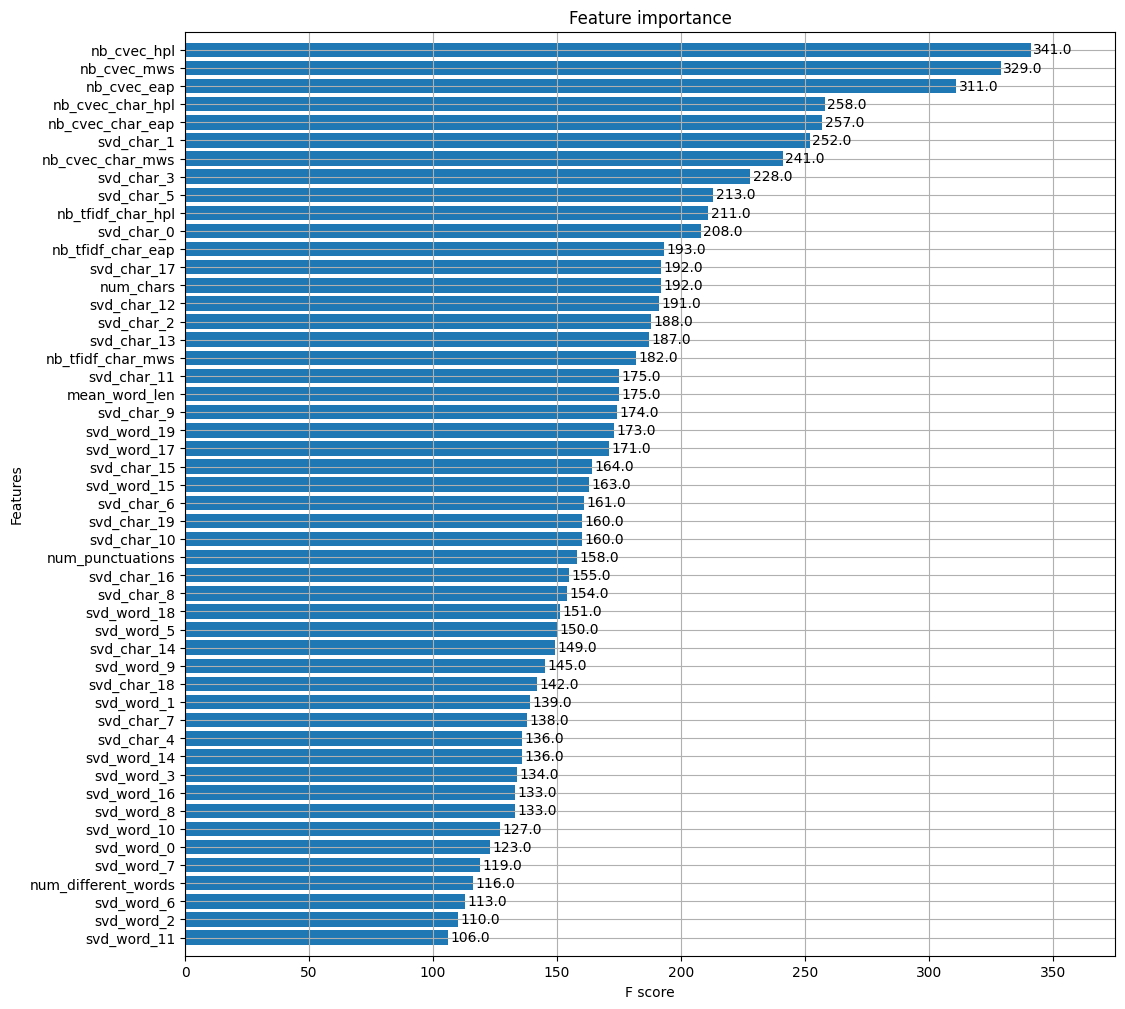

In [39]:
# Plot the important variables #
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Confusion matrix, without normalization
[[1418   72  105]
 [  98  957   43]
 [ 121   40 1061]]


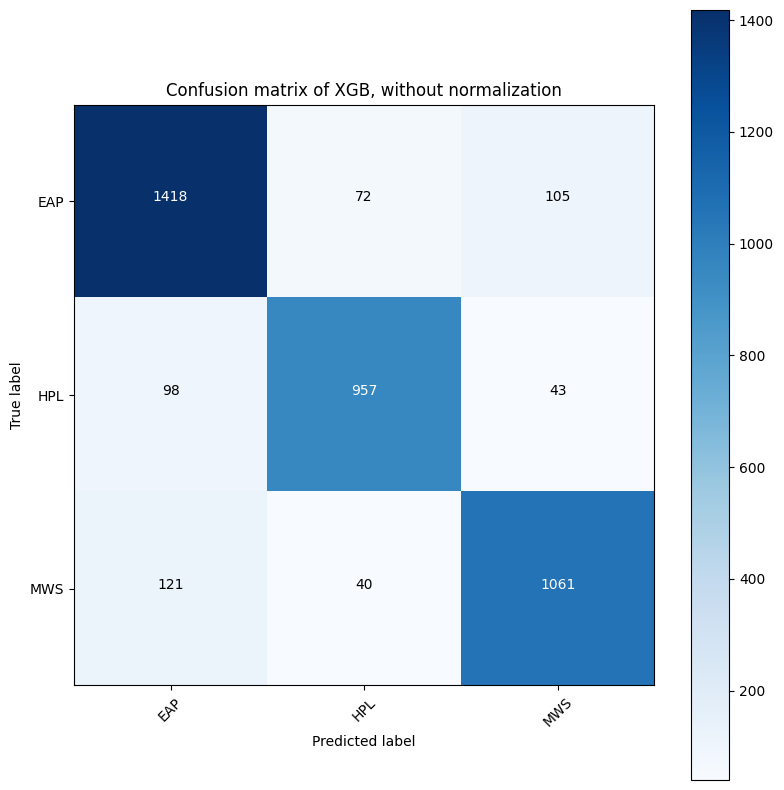

In [40]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

In [41]:
from google.colab import files

files.download('sub_fe.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>